# Denoising Diffusion Probabilistic Model in 1 Dimension

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from numpy import random
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

We generate 2000 random numbers between in (0,1) and then change the distribution arbitrarily

tensor([-3.5000, -2.2500, -3.2500,  0.2500, -0.5000,  0.0000, -4.0000,  0.5000,
         0.0000, -1.7500], device='cuda:1')


<AxesSubplot: ylabel='Density'>

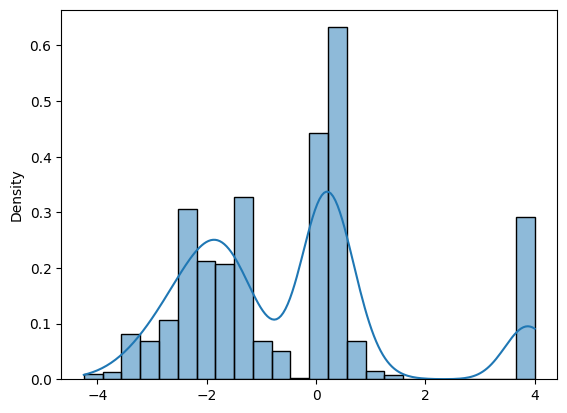

In [3]:
x0 = -np.random.poisson(8, 1000)
x0= np.append(x0,np.random.poisson(1, 800))
x0= np.append(x0,np.random.rand(200)+15)
x0=x0/4
np.random.shuffle(x0)
x_0 = torch.tensor(x0).to(torch.float32).to(device)      #mischiamo i dati iniziali
print(x_0[:10])
len_data = len(x_0)

sns.histplot(x0, stat="density", kde="True")    #plot the distribution

We define now the values of $T, \beta_t, \alpha_t, \overline \alpha_t$, for any $t \in \{0,\dots, T\}$. This choice of parameters has been done carefully empiricall y experimenting which one is the best, this is a key step because we are working with a relatively small dataset and neither  $T$ is obviously not infinite.

In [4]:
beta_0 = .0004
beta_T = .06
T = 100

betas = np.linspace(beta_0, beta_T, T)     #the betas grows linearly from beta0 to betaT

alphas = 1 - betas

betas = torch.tensor(betas).to(torch.float32).to(device)
alphas = torch.tensor(alphas).to(torch.float32).to(device)
    
list_bar_alphas = torch.cumprod(alphas, axis=0).to(torch.float32).to(device)

## Forward "noising" process

We define now the function that gives us the $x_t$ given $x_0$ thanks to the formula $x_t(x_0)=\sqrt{\overline \alpha_t} x_0 + \sqrt{1-\overline \alpha_t}z$

In [5]:
def p_forward(x_time0, t, bar_alphas, device):

    alpha_bar_t = bar_alphas[t]
    
    mean = torch.sqrt(alpha_bar_t)*x_time0
    sigma2 = torch.eye(x_time0.shape[0]).to(device)
    sigma2 = sigma2*(1-alpha_bar_t)
    return torch.distributions.MultivariateNormal(mean,sigma2).sample().to(device)

Let us now plot how the distribution $p(x_0)$ evolves in time using the funtion above. It is clear that $p(x_T) \sim \mathcal{N}(0,1)$.

Text(0.5, 1.0, 't=100')

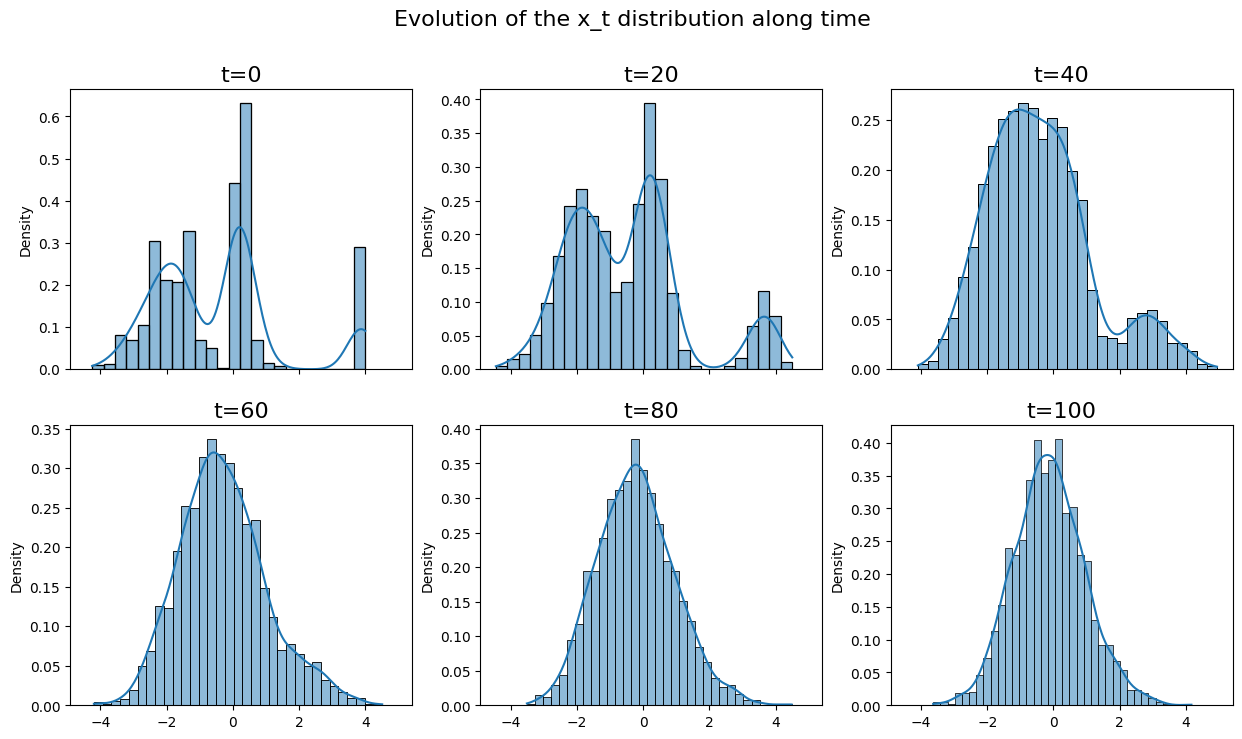

In [6]:
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(15,8))
fig.suptitle('Evolution of the x_t distribution along time', fontsize=16)
sns.histplot(x_0.cpu(),stat="density", kde="True", ax=axes[0][0])
axes[0][0].set_title('t=0',fontsize=16)
sns.histplot(p_forward(x_0, 20, list_bar_alphas, device).cpu(),stat="density", kde="True", ax=axes[0][1])
axes[0][1].set_title('t=20', fontsize=16)
sns.histplot(p_forward(x_0, 40, list_bar_alphas, device).cpu(),stat="density", kde="True", ax=axes[0][2])
axes[0][2].set_title('t=40', fontsize=16)
sns.histplot(p_forward(x_0, 60, list_bar_alphas, device).cpu(),stat="density", kde="True", ax=axes[1][0])
axes[1][0].set_title('t=60', fontsize=16)
sns.histplot(p_forward(x_0, 80, list_bar_alphas, device).cpu(),stat="density", kde="True", ax=axes[1][1])
axes[1][1].set_title('t=80', fontsize=16)
sns.histplot(p_forward(x_0, 99, list_bar_alphas, device).cpu(),stat="density", kde="True", ax=axes[1][2])
axes[1][2].set_title('t=100', fontsize=16)

We can also plot some trajectories for some numbers of points of the distribution $p(x_0)$.  We'll see that starting from our arbitrary distribution $p(x_0)$ the trajectories converge to some point symmetric with respect to $0$, exactly as the points distributed as a $\mathcal{N}(0,1)$.

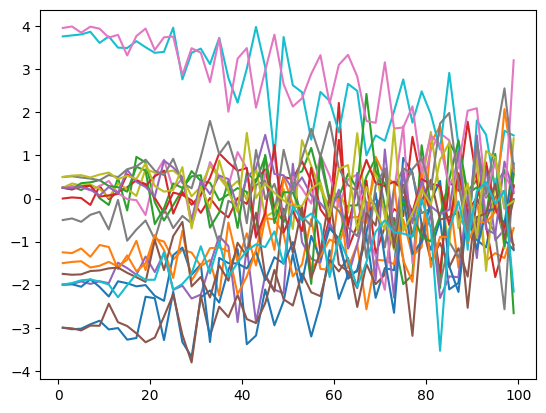

In [7]:
indts=[rd.randrange(0, len_data-1) for j in range(20)]
xx0=[]
tt=range(1,T,2)
xx0.append(x0[indts])
for t in tt:
    xx0.append(p_forward(x_0[indts], t, list_bar_alphas, device).cpu().detach().numpy())
plt.plot(tt,xx0[:len(tt)])

Text(0.5, 1.0, 't=100')

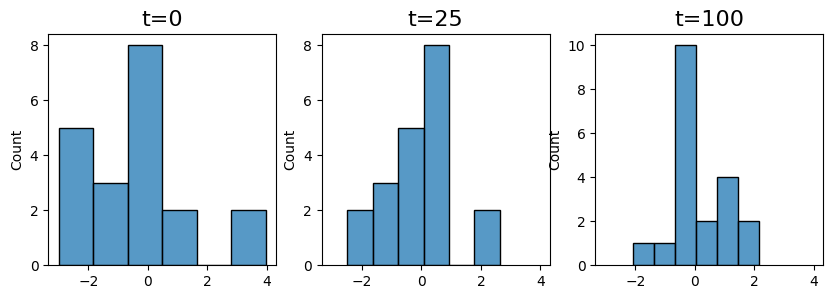

In [8]:
fig, axes = plt.subplots(1,3, sharex=True, figsize=(10,3))
sns.histplot(xx0[0],stat="count", ax=axes[0])
axes[0].set_title('t=0',fontsize=16)
sns.histplot(xx0[25],stat="count", ax=axes[1])
axes[1].set_title('t=25', fontsize=16)
sns.histplot(xx0[len(xx0)-1],stat="count", ax=axes[2])
axes[2].set_title('t=100', fontsize=16)

## Estimate for the denoising process

First, let us define the dunction that, given $x_t, t, x_0$ evaluates $\tilde \mu(x_t)$ which is the mean of the distribution $p(x_{t-1}|x_t,x_0)$ analitically computed. We could also eveluate $\tilde \Sigma_t$ but it is not necessary actually.

In [9]:
def tildemu(x_time0, x_t, t, alphas, bar_alphas, device):
    beta_t = 1 - alphas[t]
    alpha_t = alphas[t]
    alpha_bar_t = bar_alphas[t]
    alpha_bar_tminus1 = bar_alphas[t-1]
    
    tilde_mu= x_time0* torch.sqrt(alpha_bar_tminus1) * beta_t / (1 - alpha_bar_t) + x_t * torch.sqrt(alpha_t)*(1- alpha_bar_tminus1)/ (1 - alpha_bar_t)
      
    return tilde_mu

Let us define the neural model which objective will be to estimate $\mu_{\theta}(x_t)$ in such a way that it minimizes the MSE between it and $\tilde \mu(x_t)$ on our data for randomly picked times $t$, this will be more clear when we define the training session. First we define the positional encoder and then the simple neural architecture. The model could be surely improved a lot, but it goes beyond the aim of this notebook in which we want to show and make understandable the principal feature of these processes.

In [10]:
def position_encoding_init(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(10000, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return torch.from_numpy(P).to(torch.float32)

In [11]:
class Denoise(torch.nn.Module):

    def __init__(self, len_x, T):
        super(Denoise, self).__init__()

        self.linear1 = torch.nn.Linear(len_x, len_x)
        self.emb = position_encoding_init(T,len_x)
        self.linear2 = torch.nn.Linear(len_x, len_x)
        self.linear3 = torch.nn.Linear(len_x, len_x)
        self.relu = torch.nn.ReLU()

    def forward(self, input_x, t):
        emb_t = self.emb[t]
        x = self.linear1(input_x+emb_t)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

We define now the parameters used for the training

In [12]:
times_used_per_epoch= 400      #at each epoch it will take this number of time step to evaluate the MSE and minimizing it
num_epochs=20

criterion = nn.MSELoss()
model = Denoise(len_data, T).to(device)
model.emb = model.emb.to(device)
optimizer = optim.AdamW(model.parameters())

Training

In [13]:
pbar= tqdm(range(num_epochs))

for epoch in pbar:  # loop over the dataset multiple times
    running_loss = 0.0
    times = np.random.randint(1,T, times_used_per_epoch)
    #times=range(1,T)
    for _, t in enumerate(times):
        # produce corrupted sample
        x_t = p_forward(x_0, t, list_bar_alphas, device)
                
        # calculate the mean and variance of the posterior forward distribution q(x_t-1 | x_t,x_0)
        tilde_mu_t = tildemu(x_0, x_t, t, alphas, list_bar_alphas, device)
        # zero the parameter gradients
        optimizer.zero_grad()
  
        mu_theta_t = model(x_t , t)
        loss = criterion(tilde_mu_t, mu_theta_t)
        loss.backward()
        optimizer.step()
        running_loss += loss.detach()
    pbar.set_description('Epoch: {} Loss: {}'.format(epoch, running_loss/times_used_per_epoch))
print('Finished Training')

Epoch: 19 Loss: 0.4612228274345398: 100%|██████████| 20/20 [00:54<00:00,  2.75s/it] 

Finished Training


## Reverse "denoising" process

Let us define here the reverse process as $x_{t-1}=\mu_{\theta}(x_t)+\sqrt{\beta_t} z_t$, i.e. $x_{t-1}$ is generated from a $\mathcal{N}(\mu_{\theta}(x_t), \beta_t I)$.

In [14]:
def reverse_process(model_used, x_t, t, alphas, bar_alphas, len_x, device):
    beta_t = 1 - alphas[t]
    alpha_t = alphas[t]
    alpha_bar_t = bar_alphas[t]
    alpha_bar_tmin1 = bar_alphas[t-1]
    
    mu_theta_t = model_used(x_t,t)
    
    var=beta_t      #*(1-alpha_bar_tmin1)/(1-alpha_bar_t)
    
    #We chose as variance for the reverse process the matrix beta_t but it is an arbitrary choice, we used the one suggested in literature
    x_tminus1 = torch.distributions.MultivariateNormal(mu_theta_t, torch.diag(var.repeat(len_x))).sample().to(device)
        
    return x_tminus1

Now, we simulate this reverse process and plot the distributions going backward in time and some trajectories.

In [15]:
rev=[]
rev.append(torch.distributions.MultivariateNormal(torch.zeros(len_data),torch.eye(len_data)).sample().to(device))
for t in tqdm(range(T)):
    rev.append(reverse_process(model,rev[t],T-t-1, alphas, list_bar_alphas, len_data, device))

100%|██████████| 100/100 [00:00<00:00, 212.75it/s]


<AxesSubplot: ylabel='Density'>

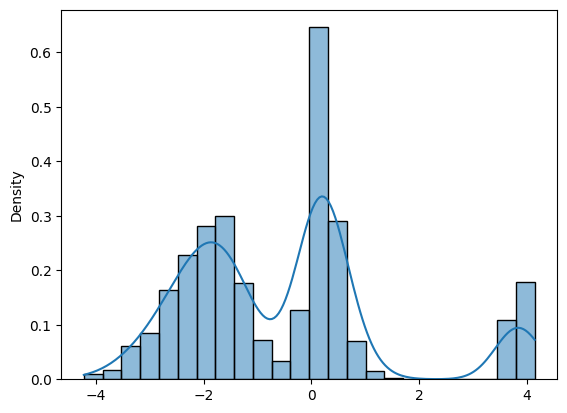

In [16]:
sns.histplot(rev[99].cpu(), stat="density", kde="True")

Text(0.5, 1.0, 't=0')

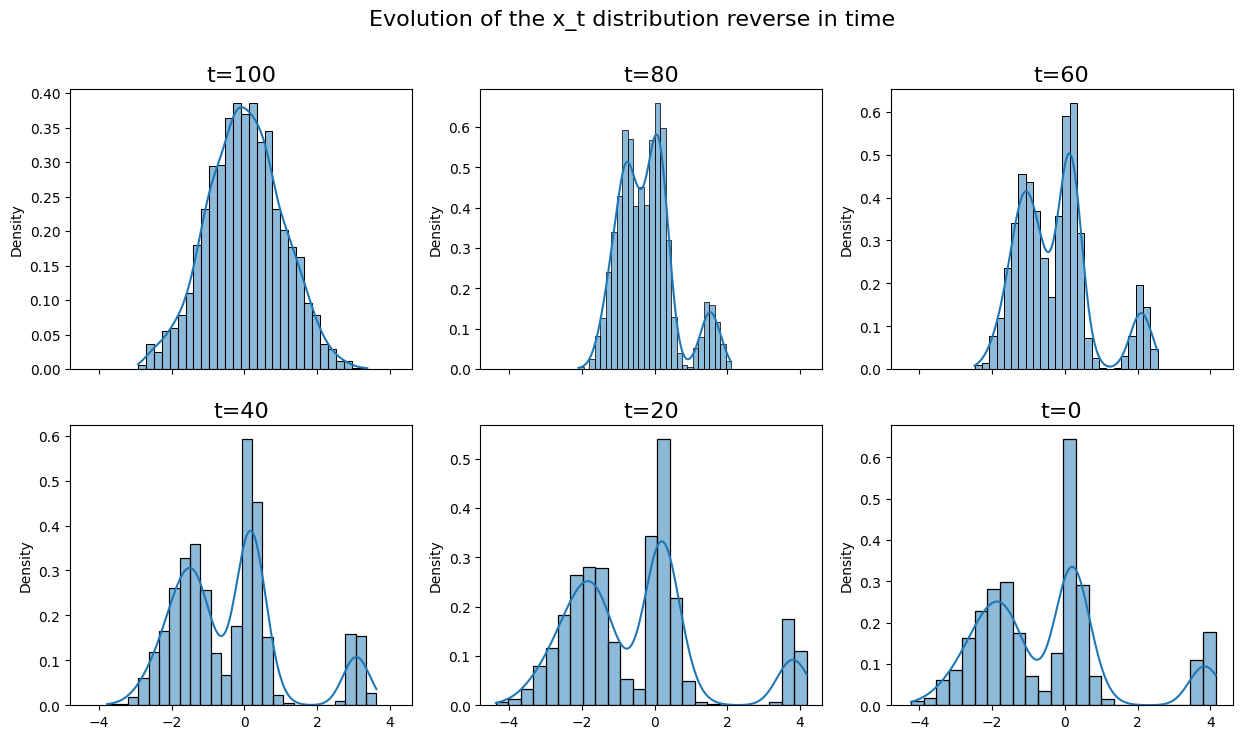

In [17]:
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(15,8))
fig.suptitle('Evolution of the x_t distribution reverse in time', fontsize=16)
sns.histplot(rev[0].cpu(), stat="density", kde="True", ax=axes[0][0])
axes[0][0].set_title('t=100',fontsize=16)
sns.histplot(rev[20].cpu(), stat="density", kde="True", ax=axes[0][1])
axes[0][1].set_title('t=80', fontsize=16)
sns.histplot(rev[40].cpu(), stat="density", kde="True", ax=axes[0][2])
axes[0][2].set_title('t=60', fontsize=16)
sns.histplot(rev[60].cpu(), stat="density", kde="True", ax=axes[1][0])
axes[1][0].set_title('t=40', fontsize=16)
sns.histplot(rev[80].cpu(), stat="density", kde="True", ax=axes[1][1])
axes[1][1].set_title('t=20', fontsize=16)
sns.histplot(rev[99].cpu(), stat="density", kde="True", ax=axes[1][2])
axes[1][2].set_title('t=0', fontsize=16)

We plot some back trajectories starting from 20 random points taken from a dsitribution $\mathcal{N}(0,1)$. It is someway evident that the process "choice" in some way in the first steps where it is heading.

/tmp/ipykernel_1874352/1269722649.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(a)


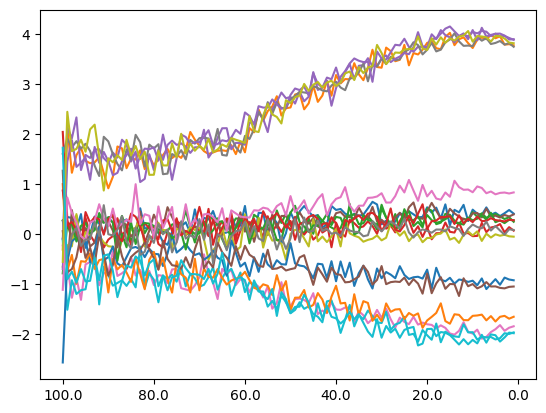

In [19]:
from pylab import *

indts2=[rd.randrange(0, len_data-1) for j in range(20)]
tt2=range(T)
label=[]
back=[ [] for _ in range(T)]
for j in range(20):
    for t in range(T):
        back[t].append(rev[t][indts2[j]].cpu())
        label.append(str(T-t))

axes = figure().add_subplot(111)
axes.plot(tt2,back)
a=axes.get_xticks().tolist()
a=a[::-1]
axes.set_xticklabels(a)
plt.show()

## Conditional densities

In this section we evaluate the conditional densities $p(x_{t-1}|x_t)$ using the $\mu_{\theta}$ that our model gave us, i.e. $\mathcal{N}(\mu_{\theta}(x_t), \beta_t I)$, and values of $x_t, x_{t-1}$ in the interval $[-1,1]$.

In [20]:
def cond_dens(model_used, x_tminus1, x_t, t, betas):    #analytical density function for a normal of the form that we found
    sqrtbeta_t=torch.sqrt(betas[t])
    mu_theta_t=model_used(x_t,t)
    A=(sqrt(2*np.pi)*sqrtbeta_t)**(-1)
    B= -0.5*((x_tminus1-x_t)/sqrtbeta_t)**2
    f = A*torch.exp(B)
    return f

In [21]:
ax_xt=torch.tensor(np.linspace(-1, 1, len_data)).to(torch.float32).to(device)

prob_dens=[ [] for _ in range(T)]
for tx in tqdm(range(T)):
    for x_tminus1 in ax_xt:
        prob_dens[tx].append(cond_dens(model, x_tminus1 ,ax_xt , torch.tensor(tx).to(device), betas).cpu().detach().numpy())

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


In [22]:
list_prob=[]
for tx in tqdm(range(T)):
    list_prob.append(np.array([l.tolist() for l in prob_dens[tx]]))

100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


In [23]:
ixti=ax_xt.cpu().detach().numpy()
list_prob[1].shape

(2000, 2000)

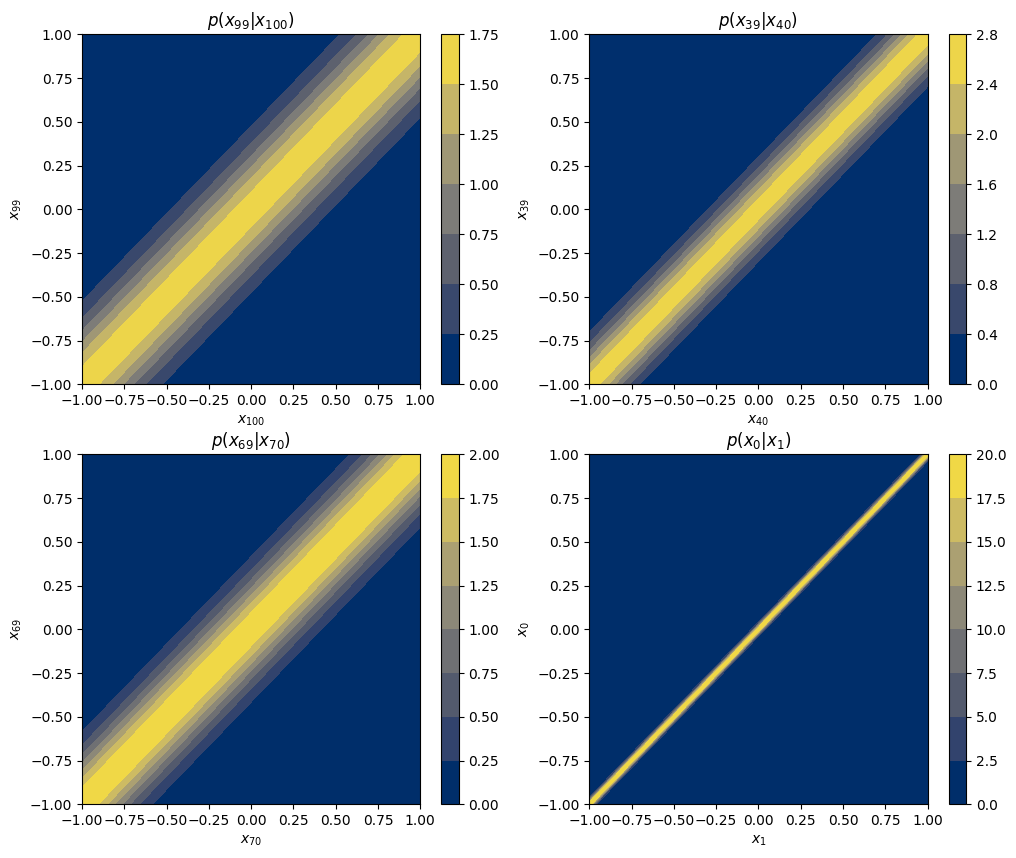

In [24]:
X, Y = meshgrid(ixti,ixti)
fig, axs = plt.subplots(2, 2, figsize=(12,10))
ttt=[99, 69, 39, 0]
i=0
for col in range(2):
    for row in range(2):
        ax = axs[row, col]
        pcm = ax.contourf(X,Y,list_prob[ttt[i]], cmap='cividis')
        ax.set(xlabel='$x_{}$'.format('{'+str(ttt[i]+1)+'}'), ylabel='$x_{}$'.format('{'+str(ttt[i])+'}'), title='$p(x_{}|x_{})$'.format('{'+str(ttt[i])+'}','{'+str(ttt[i]+1)+'}' ))
        fig.colorbar(pcm, ax=ax)
        i=i+1



# Frequences and joint probabilities

In this section we analyze the empirical distributions of the form $p(x_{t'}, x_t)$ obtained with the trajectories that we estimated.

In [26]:
print(max(rev[0]), min(rev[0]))

tensor(3.3854, device='cuda:1') tensor(-2.9197, device='cuda:1')


In [27]:
quant=40
xx0=linspace(-5.5,5.5,quant)     #discretizing the interval in which the x_t s take values 

XX, YY = meshgrid(xx0,xx0)


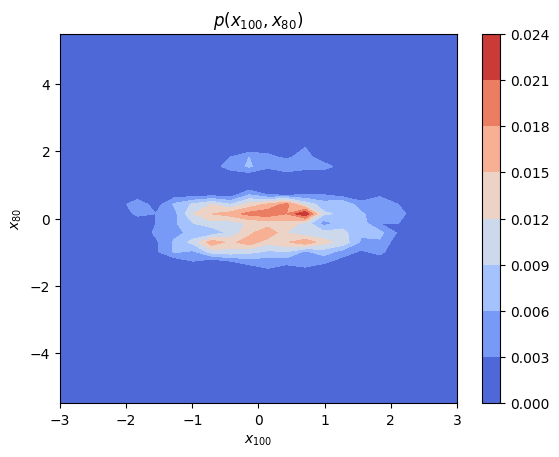

In [28]:
tempo2=80           #t'
tempo1=100           #t

rev_t1=T-tempo1    
rev_t2=T-tempo2
aa=rev[rev_t1].cpu().detach().numpy() 
bb=rev[rev_t2].cpu().detach().numpy()
freq=np.zeros((quant,quant))      

for i in range(len(aa)):
    j=0
    jb=0
    while aa[i]>xx0[j]:
        if j>quant-2:
            break
        j=j+1
    while bb[i]>xx0[jb]:
        if jb>quant-2:
            break
        jb=jb+1
    freq[jb][j]=freq[jb][j]+1


fig = plt.figure()
ax = fig.add_subplot(111)

surf = ax.contourf(XX, YY, freq/sum(freq), cmap=cm.coolwarm,)
ax.set_xlim(-3, 3)
ax.set(xlabel='$x_{}$'.format('{'+str(tempo1)+'}'), ylabel='$x_{}$'.format('{'+str(tempo2)+'}'), title='$p(x_{},x_{})$'.format('{'+str(tempo1)+'}','{'+str(tempo2)+'}'))
fig.colorbar(surf)

plt.show()

Below we create a video with the plots that we obtained fxing $t=100$ and varying $t'$ from $99$ to $0$. It is possible to see how the final distribution appears.

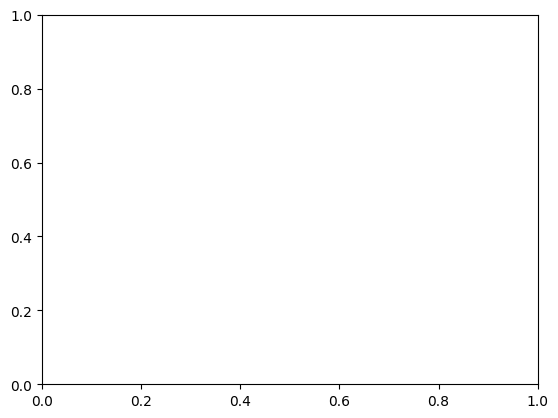

In [32]:
tempo1=T
rev_t1=T-tempo1
aa=rev[rev_t1].cpu().detach().numpy()

quant=40
xx0=linspace(-5.5,5.5,quant)     #discretizing the interval in which the x_t s take values 
XX, YY = meshgrid(xx0,xx0)


fig, ax = plt.subplots()
 
for t in range(1,T):
     
    # clear
    freq=np.zeros((quant,quant))
    
    tempo2=t
    #frequencies tab
    rev_t2=T-t
    bbt=rev[tempo2].cpu().detach().numpy()
    for i in range(len(aa)):
        j=0
        jb=0
        while aa[i]>xx0[j]:
            if j>quant-2:
                break
            j=j+1
        while bbt[i]>xx0[jb]:
            if jb>quant-2:
                break
            jb=jb+1
        freq[jb][j]=freq[jb][j]+1

#    ax.clear()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    surf=ax.contourf(XX, YY, freq/sum(freq), cmap=cm.coolwarm,)
    ax.set_xlim(-3, 3)
    ax.set(xlabel='$x_{}$'.format('{'+str(tempo1)+'}'), ylabel='$x_{}$'.format('{'+str(rev_t2)+'}'), title='$p(x_{},x_{})$'.format('{'+str(tempo1)+'}','{'+str(rev_t2)+'}'))
    #fig.colorbar(surf)
    # returning numpy image
    fig.savefig('./plotsLast/{}.png'.format(t))
    plt.close(fig)

#animation = VideoClip(make_frame, duration = duration)

#animation.ipython_display(fps = 2, loop = True, autoplay = True)

In [33]:
import os
import glob
from natsort import natsorted
from moviepy.editor import *


gif_name = 'pic'
fps = 24

file_list = glob.glob('./plotsLast/*.png')  # Get all the pngs in the current directory
file_list_sorted = natsorted(file_list,reverse=False)  # Sort the images

clips = [ImageClip(m).set_duration(0.25)
         for m in file_list_sorted]

len(file_list_sorted)
concat_clip = concatenate_videoclips(clips, method="chain")
concat_clip.write_videofile("LastVideo.mp4", fps=fps)

t:  23%|██▎       | 136/594 [00:47<00:02, 159.80it/s, now=None]

Moviepy - Building video LastVideo.mp4.
Moviepy - Writing video LastVideo.mp4




t:  23%|██▎       | 136/594 [00:52<00:02, 159.80it/s, now=None]

Moviepy - Done !
Moviepy - video ready LastVideo.mp4


In [34]:
from IPython.display import Video

Video("LastVideo.mp4")

## GMM - Gaussian Mixture Model

In this section we model the joint probability distribution $p(x_0, x_{100})$ as a combination of Gaussian random distributions.

In [35]:
from sklearn import mixture
x100=rev[0].cpu().detach().numpy()
x0=rev[len(rev)-1].cpu().detach().numpy()

X=np.array([x100,x0]).T

Text(0, 0.5, 'x0')

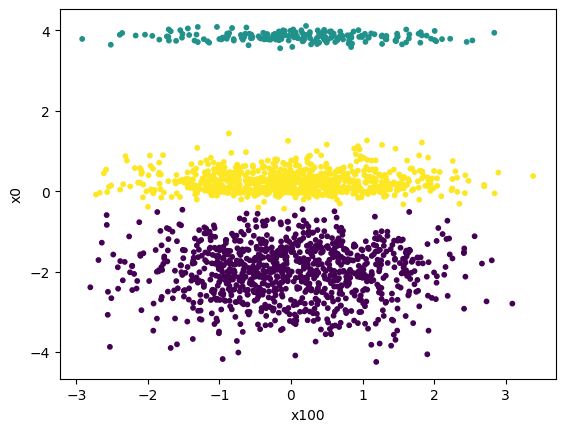

In [36]:
GMM = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm = GMM.fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis')
plt.xlabel("x100")
plt.ylabel("x0")

Below we generate new sample from the distribution taht we just estimated and see if they fits, at least graphically, the distribution found with the previous simulations.

In [37]:
data_new = gmm.sample(1000)
#sns.histplot(data_new[0], stat="density", kde="True")    #plot the distribution
generated=data_new[0]

generatedx0=[]
X_gen=[]
for i in enumerate(generated):
    generatedx0.append(i[1][1])
    X_gen.append(i[1][0])

<AxesSubplot: ylabel='Density'>

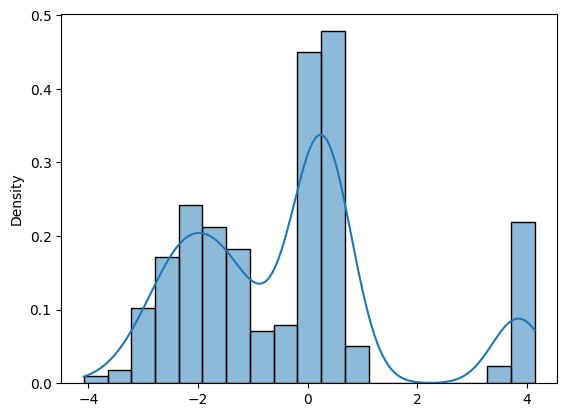

In [38]:
sns.histplot(generatedx0, stat="density", kde="True")

Text(0, 0.5, 'x0 generated by GMM')

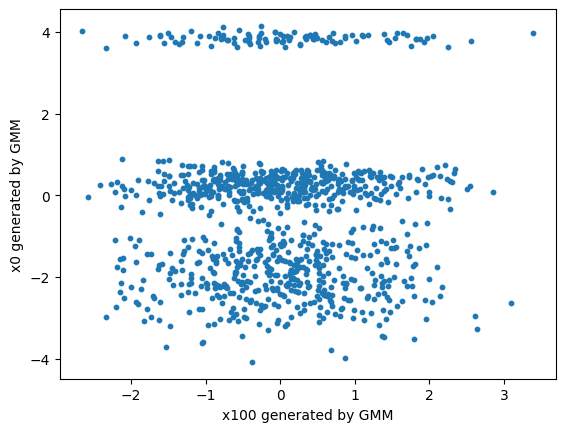

In [39]:
plt.scatter(X_gen, generatedx0, s=10)
plt.xlabel("x100 generated by GMM")
plt.ylabel("x0 generated by GMM")

### Below we use the same approach to model $p(x_{100}-x_0,x_0)$.

Now, we do the same thing, considering $x_0$ depending on $x_{100}-x_0$

Text(0, 0.5, 'x0')

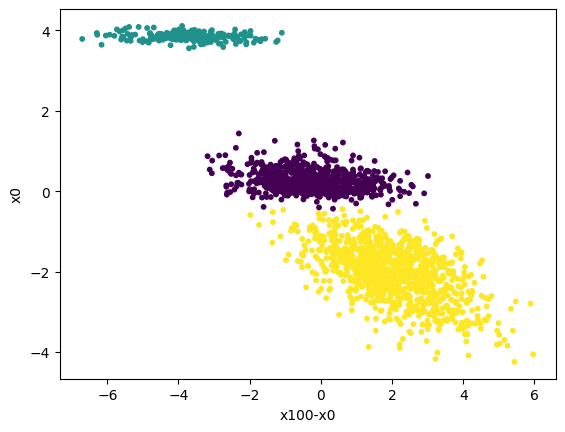

In [40]:
XX=np.array([x100-x0,x0]).T

GMM2 = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm2 = GMM2.fit(XX)
labels = gmm2.predict(XX)
plt.scatter(XX[:, 0], XX[:, 1], c=labels, s=10, cmap='viridis')
plt.xlabel("x100-x0")
plt.ylabel("x0")

In [41]:
data_new2 = gmm2.sample(1000)
#sns.histplot(data_new[0], stat="density", kde="True")    #plot the distribution
generated2=data_new2[0]

generatedx02=[]
X_gen2=[]
for i in enumerate(generated2):
    generatedx02.append(i[1][1])
    X_gen2.append(i[1][0])

<AxesSubplot: ylabel='Density'>

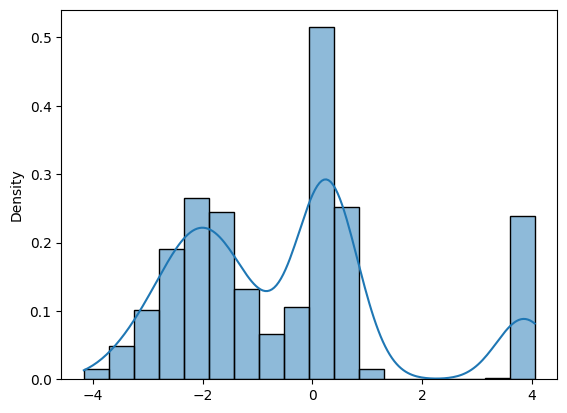

In [42]:
sns.histplot(generatedx02, stat="density", kde="True")

Text(0, 0.5, 'x0 generated by GMM')

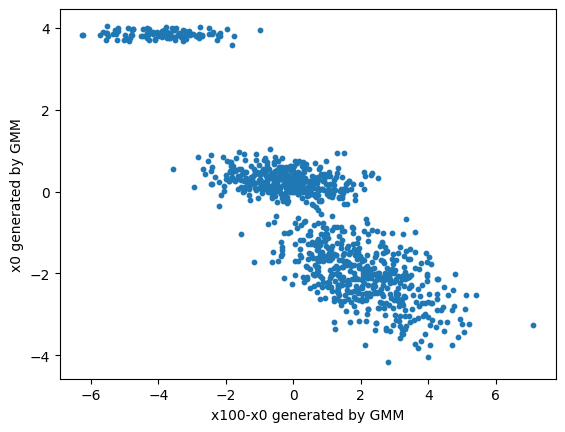

In [43]:
plt.scatter(X_gen2, generatedx02, s=10)
plt.xlabel("x100-x0 generated by GMM")
plt.ylabel("x0 generated by GMM")

### Without reverse diffusion process

In 1-dimension, being the data and the initial distribution much simpler than real images, it is possible to generate new elements of the initial distribution simply generating a GMM fitting all the $x_0$ passed to the model and then sampling elements from this model. In the literature, for example in https://arxiv.org/pdf/2104.12686.pdf is pointed out that it is not a doable approach to images generation due to the great amount of gaussian components that would be necessary to model such distributions.

In [44]:
xorig=x0

In [45]:
xfor=p_forward(x_0, 99, list_bar_alphas, device).cpu().detach().numpy()

[[-0.08079702 -3.3052366 ]
 [-1.0568831  -2.2087743 ]
 [-0.318338   -3.2171023 ]
 [ 0.7171948   0.30832234]]


Text(0, 0.5, 'x0 data')

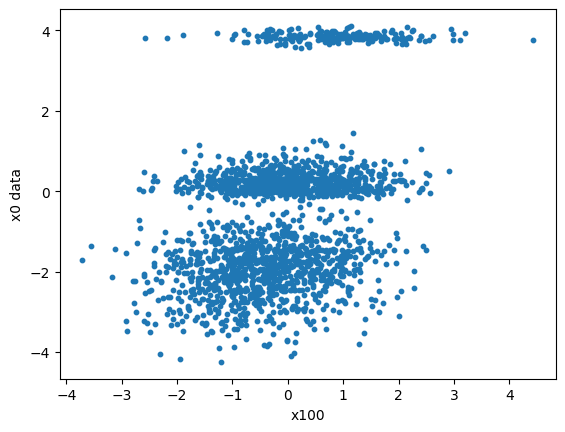

In [46]:
Xp=np.array([xfor,xorig]).T
print(Xp[:4])

plt.scatter(Xp[:,0], Xp[:,1], s=10)
plt.xlabel("x100")
plt.ylabel("x0 data")

In [49]:
GMM0 = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm0 = GMM0.fit(Xp)
data_new0 = gmm0.sample(1000)
generated0=data_new0[0]



generatedx00=[]
X_gen0=[]
for i in enumerate(generated0):
    generatedx00.append(i[1][1])
    X_gen0.append(i[1][0])



<AxesSubplot: ylabel='Density'>

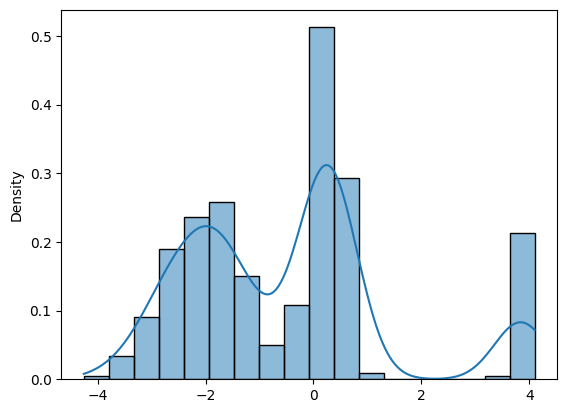

In [50]:
sns.histplot(generatedx00, stat="density", kde="True")